<a href="https://colab.research.google.com/github/ManuSinghYadav/Walmart-Sales-Forecast/blob/main/Walmart_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing the Data
It can be downloaded from [here](https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast).

In [2]:
!pip install pmdarima

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [4]:
features = pd.read_csv('/content/Walmart-Sales-Forecast/features.csv')
stores = pd.read_csv('/content/Walmart-Sales-Forecast/stores.csv')
test = pd.read_csv('/content/Walmart-Sales-Forecast/test.csv')
train = pd.read_csv('/content/Walmart-Sales-Forecast/train.csv')

<ipython-input-4-ad108aaf380d>:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/Walmart-Sales-Forecast/train.csv')


##Basic Exploration

In [5]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [7]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [8]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309679 entries, 0 to 309678
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         309679 non-null  int64  
 1   Dept          309679 non-null  int64  
 2   Date          309679 non-null  object 
 3   Weekly_Sales  309679 non-null  float64
 4   IsHoliday     309678 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ MB


In [10]:
train.describe()

,Store,Dept,Weekly_Sales
count,309679.000000,309679.000000,309679.000000
mean,16.219340,43.414981,17140.600746
std,9.071128,29.839534,23941.832113
min,1.000000,1.000000,-4988.940000
25%,8.000000,19.000000,2661.720000
50%,16.000000,36.000000,8337.490000
75%,24.000000,71.000000,21601.720000
max,32.000000,99.000000,693099.360000


In [11]:
max(train['Date'])

'2012-10-26'

In [12]:
min(test['Date'])

'2012-11-02'

In [13]:
print("Stores:", np.sort(train['Store'].unique()))

print("\nTotal Stores:", len(train['Store'].unique()))

Stores: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]

Total Stores: 32


In [14]:
print("Departments:", np.sort(train['Dept'].unique()))

print("\nTotal Departments:", len(train['Dept'].unique()))

Departments: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91
 92 93 94 95 96 97 98 99]

Total Departments: 80


In [15]:
print("Total Unique Weeks:", len(train['Date'].unique()))

Total Unique Weeks: 143


In [16]:
train.groupby(['Store','Dept']).count()

Date  Weekly_Sales  IsHoliday
Store Dept                               
1     1      143           143        143
      2      143           143        143
      3      143           143        143
      4      143           143        143
      5      143           143        143
...          ...           ...        ...
32    38     143           143        143
      40     143           143        143
      41     143           143        143
      42     143           143        143
      44     138           138        137

[2404 rows x 3 columns]

In [17]:
# @title Analysis/ Result
# @markdown From the above analyis, it can be analyzed that we have **32 Stores** and *almost* each store is having **80 Departments**. And *almost* each department is having data for **143 weeks**.

# @markdown It seems it has many columns which can be treated as exogenous variables. Will use them later.


##Data Preprocessing


Removing NaN rows

In [18]:
train = train.dropna()

Setting up the index

In [19]:
train.index = train['Date']

In [20]:
train = train.drop(['Date'], axis = 1)

In [21]:
train.index = pd.to_datetime(train.index)

In [22]:
train.index.dtype

dtype('<M8[ns]')

Label Encoding of 'IsHoliday' column.

In [23]:
l_e = LabelEncoder()
train['IsHoliday']= l_e.fit_transform(train['IsHoliday'])
train

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,0
2010-02-12,1,1,46039.49,1
2010-02-19,1,1,41595.55,0
2010-02-26,1,1,19403.54,0
2010-03-05,1,1,21827.90,0
...,...,...,...,...
2012-08-17,32,44,5656.19,0
2012-08-24,32,44,4533.20,0
2012-08-31,32,44,3767.29,0


##Resample the data
Merge all the rows on the basis of weeks.

In [24]:
df = pd.DataFrame(train.resample(rule = 'W').mean())
df

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-07,16.172761,43.250914,18117.921143,0.0
2010-02-14,16.163777,43.412865,17529.432641,1.0
2010-02-21,16.157059,43.386745,17409.342306,0.0
2010-02-28,16.148352,43.070971,15903.966896,0.0
2010-03-07,16.141020,43.022967,16971.829812,0.0
...,...,...,...,...
2012-09-30,16.160277,43.429099,15738.767607,0.0
2012-10-07,16.199172,43.791168,17115.639894,0.0
2012-10-14,16.181361,43.915487,16422.246725,0.0


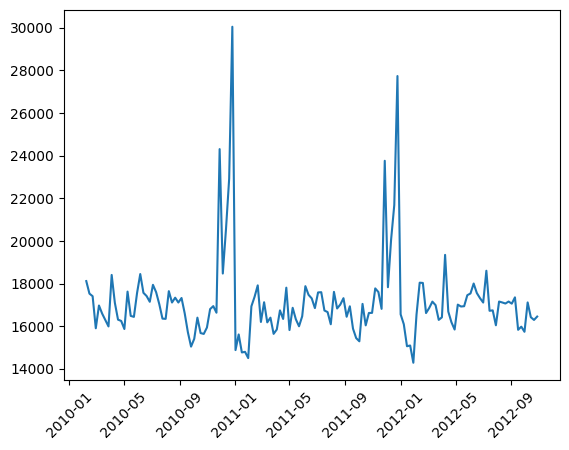

In [25]:
plt.plot(df['Weekly_Sales'])
plt.xticks(rotation=45);

##Stationarity

In [26]:
adf = adfuller(df['Weekly_Sales'])
print("P-Value:",adf[1])

P-Value: 1.603633935400217e-07


It is already stationary.

##Train Test Split

In [40]:
train_eval = df[:-33]
test_eval = df[-33:]
len(train_eval)

110

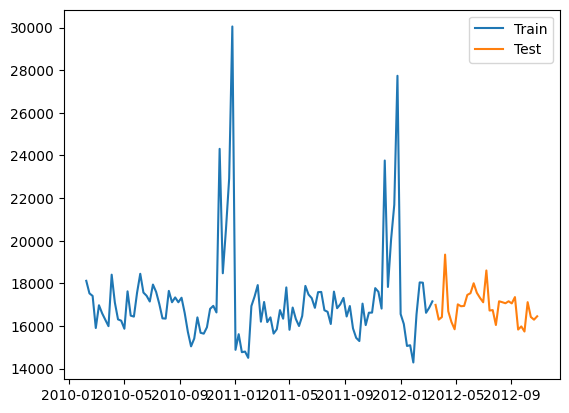

In [41]:
plt.plot(train_eval['Weekly_Sales'], label='Train')
plt.plot(test_eval['Weekly_Sales'], label='Test')
plt.legend();

##Forecasting with SARIMA

###Auto_Arima

It is for finding the right parameters for the ARIMA based models.

In [42]:
auto_arima(train_eval['Weekly_Sales'], seasonal = True, m=52)

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(1, 0, 1, 52),
      suppress_warnings=True)

In [43]:
auto_arima(train_eval['Weekly_Sales'], seasonal = True, m=7)

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 7),
      suppress_warnings=True)

###Fitting

In [69]:
model_sarima = SARIMAX(train_eval['Weekly_Sales'],order=(2,0,2),seasonal_order=(1,0,1,52)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [70]:
start=len(train_eval)
end=len(train_eval)+len(test_eval)-1
pred_sarima = model_sarima.predict(start=start, end=end, dynamic=False)

###Plotting

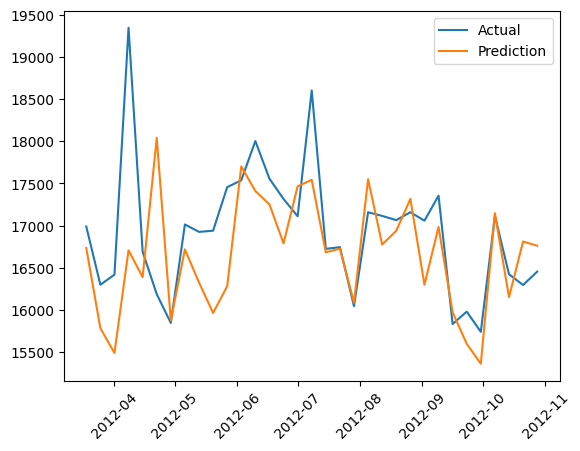

In [71]:
plt.plot(test_eval['Weekly_Sales'], label='Actual')
plt.plot(pred_sarima, label='Prediction')
plt.xticks(rotation = 45)
plt.legend();

###Evaluation

In [72]:
print("MAE:", MAE(pred_sarima, test_eval['Weekly_Sales']))
print("RMSE:", MSE(pred_sarima, test_eval['Weekly_Sales'])**0.5)

MAE: 510.803437608378
RMSE: 743.9273044570964


##Forecasting with SARIMAX

In this we'll pass **holiday** column as an exogneous variable.

###Auto_Arima

In [81]:
auto_arima(train_eval['Weekly_Sales'], exog=train_eval['IsHoliday'], seasonal = True, m=52)

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(1, 0, 1, 52),
      suppress_warnings=True)

###Fitting

In [74]:
model_sarimax = SARIMAX(train_eval['Weekly_Sales'],exog=train_eval['IsHoliday'],order=(2,0,2),seasonal_order=(1,0,1,52)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [78]:
start=len(train_eval)
end=len(train_eval)+len(test_eval)-1
pred_sarimax = model_sarimax.predict(start=start, end=end, exog=test_eval['IsHoliday'], dynamic=False)

###Plotting

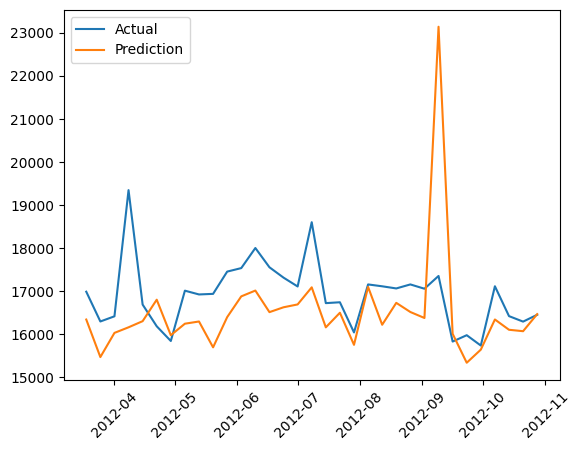

In [79]:
plt.plot(test_eval['Weekly_Sales'], label='Actual')
plt.plot(pred_sarimax, label='Prediction')
plt.xticks(rotation = 45)
plt.legend();

###Evaluation

In [80]:
print("MAE:", MAE(pred_sarimax, test_eval['Weekly_Sales']))
print("RMSE:", MSE(pred_sarimax, test_eval['Weekly_Sales'])**0.5)

MAE: 815.386909576506
RMSE: 1325.1870486326934


In [86]:
# @title Analysis / Result
# @markdown It can be seen the SARIMAX is not performing well on the dataset, in comparison to SARIMA. In plot, a clear spike can be seen on holiday. It seems it overestimated the effect of holidays.""